# Graduation Rate Data Exploration
In this notebook we look at elementary/secondary school data from the United States to hopefully shed some light on the challenges facing schools and school districts around the country. We are going to work through the entire data modeling pipeline from data acquisition -> data wrangling -> data exploration -> visualization -> modeling

### Questions
1. Where are schools struggling the most with low graduation rates?
2. Are these schools clustered in particular regions?
3. What demographic factors are correlated with low graduation rates?
4. Can we predict graduation rate and thereby reverse engineer some of the factors influencing graduation rates?

### Datasets
- <a href=https://nces.ed.gov/opengis/rest/services/K12_School_Locations/EDGE_GEOCODE_PUBLICSCH_1819/MapServer> Public School Locations </a>
- <a href=https://www2.ed.gov/about/inits/ed/edfacts/data-files/index.html#acgr> Graduation Rates </a> 
- <a href=https://data-nces.opendata.arcgis.com/datasets/nces::public-school-characteristics-2018-19/about> Demographics </a> 

### Skills In This Notebook
- REST queries
- Data Exploration
- Data Visualization
- Modeling/Prediction

***
## Imports
<code> pandas </code> data manipulation <br>
<code> plotly </code>   visualizations <br>
<code> requests </code>  manage our data scraping <br>
<code> dash </code>    interactive visualizations <br>
<code> scikitlearn </code> modeling and prediction

In [3]:
import pandas as pd
import plotly as plotly
import requests as reqs
import time
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
import sklearn
import plotly.express as px
from requests.exceptions import HTTPError
from dash.dependencies import Input, Output

## Utility Functions
#### <code>reformat_grades(rate)</code>
removes non-numeric characters from our grades data

In [4]:
def reformat_grades(rate):
    if(rate.startswith('LE') or rate.startswith('LT') or rate.startswith('GE')):
        return rate[2:]
    if('-' in rate):
        return rate[0:rate.index('-')]
    return rate

## Data Files
<b> df_grad_rates </b> adjusted cohort graduation rates <br>
<b> df_locations </b> latitude and longitude for schools <br>
<b> df_state_abbrevs </b> mapping between state names and two letter abbreviations <br>
<b> df_demographics </b> school demographic and other characteristic data <br>

In [54]:
df_grad_rates = pd.read_csv("../Data/18_19_Graduation_Rates.csv")
df_locations = pd.read_csv("../Data/school_geo_data.csv")
df_state_abbrevs = pd.read_csv("../Data/state_mapping.csv")
df_demographics = pd.read_csv("../Data/Public_School_Characteristics_2018-19.csv")

### Merging Data Sets
Since we are pulling data from three different locations let's get them all together so we can start to run some analysis.
To figure out our merge we are going to have a look at the columns.

In [48]:
print(df_grad_rates.columns)
print(df_locations.columns)
print(df_demographics.columns)

Index(['STNAM', 'FIPST', 'LEAID', 'ST_LEAID', 'LEANM', 'NCESSCH', 'ST_SCHID',
       'SCHNAM', 'ALL_COHORT_1819', 'ALL_RATE_1819', 'MAM_COHORT_1819',
       'MAM_RATE_1819', 'MAS_COHORT_1819', 'MAS_RATE_1819', 'MBL_COHORT_1819',
       'MBL_RATE_1819', 'MHI_COHORT_1819', 'MHI_RATE_1819', 'MTR_COHORT_1819',
       'MTR_RATE_1819', 'MWH_COHORT_1819', 'MWH_RATE_1819', 'CWD_COHORT_1819',
       'CWD_RATE_1819', 'ECD_COHORT_1819', 'ECD_RATE_1819', 'FCS_COHORT_1819',
       'FCS_RATE_1819', 'HOM_COHORT_1819', 'HOM_RATE_1819', 'LEP_COHORT_1819',
       'LEP_RATE_1819', 'DATE_CUR'],
      dtype='object')
Index(['NAME', 'STATE', 'LAT', 'LON', 'LOCALE'], dtype='object')
Index(['X', 'Y', 'OBJECTID', 'NCESSCH', 'SURVYEAR', 'STABR', 'LEAID',
       'ST_LEAID', 'LEA_NAME', 'SCH_NAME', 'LSTREET1', 'LSTREET2', 'LCITY',
       'LSTATE', 'LZIP', 'LZIP4', 'PHONE', 'GSLO', 'GSHI', 'VIRTUAL', 'TOTFRL',
       'FRELCH', 'REDLCH', 'PK', 'KG', 'G01', 'G02', 'G03', 'G04', 'G05',
       'G06', 'G07', 'G08', 'G0

**This is alot of data columns and many of them are pretty hard to interpret. Let's simplify this for our analysis**

In [55]:
df_grad_rates = df_grad_rates[['STNAM','LEAID','ST_LEAID','SCHNAM','ALL_RATE_1819']]
df_demographics = df_demographics[['LEAID', 'ST_LEAID', 'SCH_NAME', 'LSTATE','TOTFRL', 'TOTAL', 'FTE', 'LATCOD','LONCOD', 'STUTERATIO','AM', 'HI', 'BL', 'WH', 'HP','AS', 'TR','AMALF', 'ASALM', 'ASALF', 'HIALM', 'HIALF', 'BLALM', 'BLALF', 'WHALM',
       'WHALF', 'HPALM', 'HPALF', 'TRALM', 'TRALF', 'TOTMENROL', 'TOTFENROL', 'CHARTER_TEXT','MAGNET_TEXT']]

**Looks like we have a state name and a school name in all three of our dataframes. Let's have a look at these to ensure they contain what we want.**

In [56]:
print(df_grad_rates.STNAM.value_counts().head())
print(df_locations.STATE.value_counts().head())
print(df_demographics.LSTATE.value_counts().head())

CALIFORNIA    2538
TEXAS         1782
NEW YORK      1255
MICHIGAN      1111
FLORIDA       1045
Name: STNAM, dtype: int64
CA    10440
TX     9467
NY     4847
FL     4462
IL     4295
Name: STATE, dtype: int64
CA    10439
TX     9423
NY     4811
IL     4345
FL     4236
Name: LSTATE, dtype: int64


**We have a lot more data in our locations and demographics, but that makes sense since graduation rates are only being reported for high schools.**
<br>One thing we do need to fix is the state names are not abbreviated, so we are going to need to fix that before we merge. Then we are going to do a left merge onto our graduation rate dataframe because we only want to keep the data for schools in our graduation rate data.

In [57]:
#Replace state names with abbreviations
df_grad_rates['STNAM'] = df_grad_rates['STNAM'].str.lower()
df_state_abbrevs['Name'] = df_state_abbrevs['Name'].str.lower()
df_grad_rates = pd.merge(df_grad_rates,df_state_abbrevs, left_on='STNAM', right_on='Name').drop(['STNAM','Name'], axis=1)

**Let's do our merge, and we are going to use as much matching data as we can, because there are lots of schools and many of them have similar names. We are going to see that we even still have some duplicates in our data.**

In [58]:
df_full = pd.merge(df_grad_rates,df_demographics,how="left",left_on=['SCHNAM','Abbreviation','LEAID','ST_LEAID'],right_on=['SCH_NAME','LSTATE', 'LEAID','ST_LEAID'])
print(df_full.Abbreviation.value_counts().head())
df_full = pd.merge(df_full,df_locations,how="left",left_on=["SCHNAM","Abbreviation", 'LATCOD', 'LONCOD'],right_on=["NAME","STATE",'LAT','LON'])
print(df_full.Abbreviation.value_counts().head())
print(df_full.shape)

CA    2538
TX    1784
NY    1255
MI    1111
FL    1049
Name: Abbreviation, dtype: int64
CA    2538
TX    1809
NY    1255
MI    1111
FL    1054
Name: Abbreviation, dtype: int64
(22644, 42)


**Looks like we have a few duplicate rows since we see an increase in the size of our dataframe. Let's get rid of those dupes**

In [59]:
df_full.drop_duplicates(inplace=True)
df_full = df_full.T.drop_duplicates().T #dropping our duplicate columns as well
print(df_full.Abbreviation.value_counts().head()) 
print(df_full.shape)

CA    2538
TX    1784
NY    1255
MI    1111
FL    1046
Name: Abbreviation, dtype: int64
(22607, 42)


## Data Wrangling and Data Exploration

**Reformat our grades column and drop our rows where we don't have data because it was flagged as protected**

In [69]:
df_full['Grad_Rate'] = df_full['ALL_RATE_1819'].apply(reformat_grades).astype('int32') #remove letters and symbols from graduation rates
df_full = df_full[df_full.ALL_RATE_1819 != 'PS'] #drop all rows for schools where data was protected

AttributeError: 'int' object has no attribute 'startswith'

**Check distribution of our graduation rates**

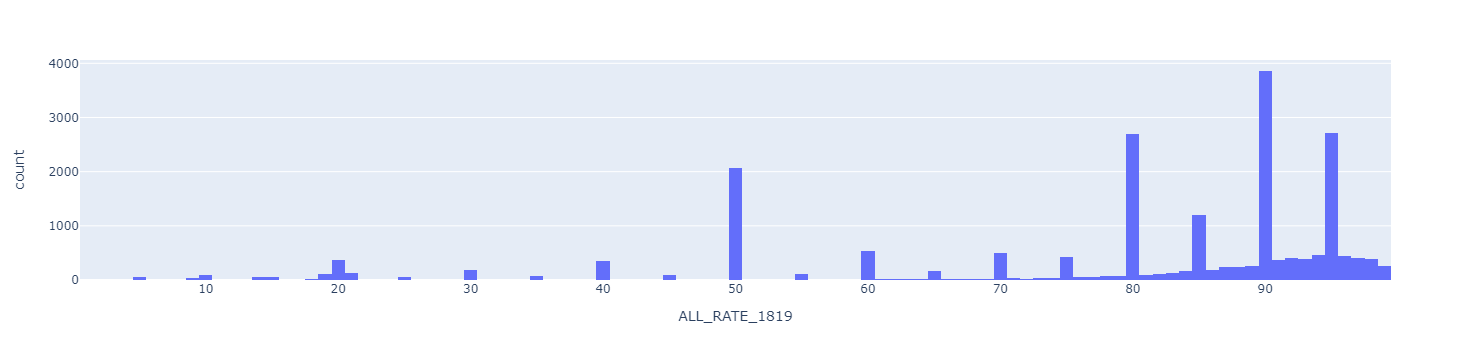

In [67]:
fig = px.histogram(df_full["ALL_RATE_1819"].sort_values(), x="ALL_RATE_1819")
fig.show()

In [68]:
#group by region and graph

In [ ]:
#combine with demographics and graph

In [7]:
df_plot["Grad_Rate"] = df_plot["ALL_RATE_1819"].astype('int32')

In [72]:
fig = px.scatter_geo(df_full,lat="LAT",lon="LON", color="ALL_RATE_1819", hover_name="SCHNAM", color_continuous_scale="inferno",scope='usa', width = 1200, height=800)

In [ ]:


app = dash.Dash()
app.layout = html.Div([
html.P("Filter by Graduation Rate"),
dcc.Slider(min=0, max=100,value=50,id="filter_slide",tooltip={"placement": "bottom", "always_visible": True}),
dcc.Graph(id="main_chart")
])

@app.callback(
    Output('main_chart', 'figure'),
    Input('filter_slide', 'value'))
def update_output(value):
    df = df_full[df_full.ALL_RATE_1819 < value]
    fig = px.scatter_geo(df,lat="LAT",lon="LON", color="ALL_RATE_1819", hover_name="SCHNAM", color_continuous_scale="inferno",scope='usa',title="Graduation Rate By School", width = 1200, height=800)
    return fig

app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
